# Prédiction et simulation des taux d'intérêts immobiliers européens

Notre projet vise à développer des modèles prédictifs pour estimer les taux d'intérêt immobilier en Europe en utilisant les rendements des obligations souveraines comme variables d'entrée. Pour atteindre cet objectif, nous avons entrepris plusieurs étapes clés.

Pour atteindre cet objectif, nous avons entrepris plusieurs étapes clés. Tout d'abord, nous avons procédé à une exploration et une analyse approfondie des données, en les manipulant et en les préparant pour nos modèles.

Tout d'abord, nous avons mis en œuvre la régression linéaire ordinaire (OLS) pour établir un point de référence solide. Ensuite, nous avons exploré les avantages des arbres de décision en utilisant la méthode Random Forest, qui permet de capturer des relations non linéaires entre les variables. Nous avons également utilisé le modèle Lasso pour sélectionner les variables les plus importantes et réduire l'overfitting. Ensuite, nous avons adopté une approche plus exploratoire en utilisant la simulation pour obtenir des aperçus supplémentaires et des scénarios hypothétiques. En outre, nous avons exploré l'utilisation du Gradient Boosting, une technique d'apprentissage ensembliste qui combine plusieurs modèles faibles pour améliorer les performances prédictives. Enfin, nous avons utilisé des techniques d'apprentissage non supervisé, telles que KMeans et PCA, pour extraire des informations clés et réduire la dimensionnalité des données dans le but de visualiser la qualité de notre clustering. En combinant ces six approches, nous avons cherché à maximiser la précision des prédictions des taux d'intérêt immobiliers et à découvrir des relations complexes entre les variables.

Tout au long de notre projet, nous cherchons à trouver le modèle le plus performant et à fournir des prédictions précises tout en utilisant un ensemble de métriques qui permettent de controler la qualité des dits modèles.


Les données viennent directement du site de la Banque de France et sont trouvables sur les liens suivants:

- [Pour les taux moyen mensuel des prêts immobiliers à taux fixe émis dans la
zone Euro dont la maturité est supérieure à 10 ans.](https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=3ced07bddbe52f0fcc6523e7ecde58a1&df=true&ec=&dc=&oc=&pb=&rc=&DATASET=1&removeItem=&removedItemList=&mergeFilter=&activeTab=MIR&showHide=&MAX_DOWNLOAD_SERIES=500&SERIES_MAX_NUM=50&node=9689358&legendRef=reference&legendPub=published&legendNor=&SERIES_KEY=124.MIR.M.U2.B.A2C.AM.R.A.2250.EUR.N)


- [Pour les taux de rendement moyen mensuel des obligations gouvernementales d’une
maturité de 10 ans dans chaque pays de l’UE](https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=2b21940a909e3351698b0d6b0a4b876f&df=true&ec=&dc=&oc=&pb=&rc=&DATASET=0&removeItem=&removedItemList=&mergeFilter=&activeTab=IRS&showHide=&MAX_DOWNLOAD_SERIES=500&SERIES_MAX_NUM=50&node=bbn4864&legendRef=reference&legendPub=published)

In [1]:
#import packages
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import scipy.stats as stats
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
import missingno as msno
from sklearn.model_selection import GridSearchCV
import plotly.graph_objs as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
#pip install missingno

In [3]:
# pip install --upgrade nbformat

## Importation de données

Ici, nous importons les données des taux de rendement moyens mensuels des obligations gouvernementales ayant une maturité de 10 ans dans chaque pays de l'Union européenne.

In [4]:
PATH_TO_YIELDS = r"eu_yields_.csv"
PATH_TO_MORTGAGE = r"eu_mortgage_rates_.csv"


In [5]:
yields = pd.read_csv(PATH_TO_YIELDS, skiprows = [0,1,3,4], index_col = 'Unnamed: 0')[::-1]

In [6]:
yields.columns

Index(['Austria, Euro', 'Belgium, Euro', 'Bulgaria, Bulgarian lev',
       'Cyprus, Euro', 'Czech Republic, Czech koruna', 'Germany, Euro',
       'Denmark, Danish krone', 'Estonia, Euro', 'Spain, Euro',
       'Finland, Euro', 'France, Euro', 'Greece, Euro',
       'Hungary, Hungarian forint', 'Ireland, Euro', 'Italy, Euro',
       'Lithuania, Euro', 'Luxembourg, Euro', 'Latvia, Euro', 'Malta, Euro',
       'Netherlands, Euro', 'Poland, Polish zloty', 'Portugal, Euro',
       'Romania, Romanian leu', 'Sweden, Swedish krona', 'Slovenia, Euro',
       'Slovakia, Euro'],
      dtype='object')

In [7]:
yields.index = list(map(lambda x: datetime.strptime(x, '%Y%b'), yields.index)) # Mise en place des dates en indices
yields.columns = map(lambda x: x.split(',')[0], yields.columns) # On renomme les colonnes uniquements avec les noms
yields.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
1993-01-01     7.22     7.57       NaN     NaN             NaN     7.15   
1993-02-01     7.13     7.65       NaN     NaN             NaN     6.94   
1993-03-01     6.86     7.37       NaN     NaN             NaN     6.66   
1993-04-01     6.93     7.44       NaN     NaN             NaN     6.68   
1993-05-01     7.06     7.43       NaN     NaN             NaN     6.83   

            Denmark  Estonia  Spain  Finland  ...  Luxembourg Latvia  Malta  \
1993-01-01     8.65      NaN  12.15    10.92  ...         NaN    NaN    NaN   
1993-02-01     8.63      NaN  11.43    10.27  ...         NaN    NaN    NaN   
1993-03-01     8.18      NaN  11.36     9.87  ...         NaN    NaN    NaN   
1993-04-01     7.79      NaN  11.49     9.77  ...         NaN    NaN    NaN   
1993-05-01     7.56      NaN  11.22     9.46  ...         NaN    NaN    NaN   

            Netherlands  Poland  Portugal  Romania  Sweden  Slovenia  Slovakia  
1993-01-01         7.13     NaN       NaN      NaN   10.17       NaN       NaN  
1993-02-01         6.87     NaN       NaN      NaN    9.83       NaN       NaN  
1993-03-01         6.56     NaN       NaN      NaN    9.40       NaN       NaN  
1993-04-01         6.60     NaN       NaN      NaN    9.44       NaN       NaN  
1993-05-01         6.67     NaN       NaN      NaN    9.12       NaN       NaN  

[5 rows x 26 columns]

In [8]:
# Remplacement des "-" par des NaN
yields['Greece'] = yields['Greece'].replace (['-'],np.nan)
yields['Greece'] = yields['Greece'].astype(float)

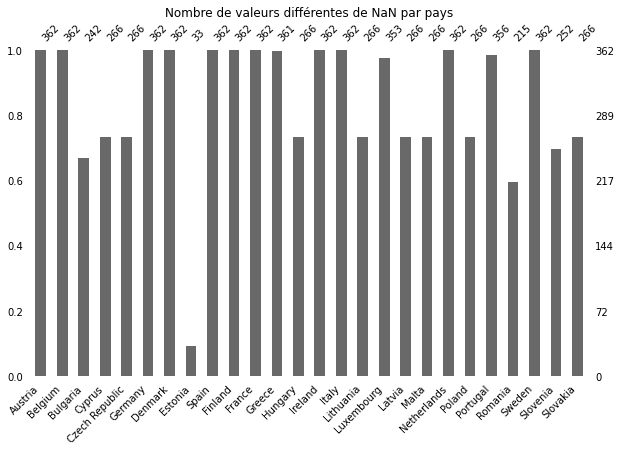

In [9]:
msno.bar(yields, figsize=(10,6), fontsize=10) # plot barchart of missing values
plt.title('Nombre de valeurs différentes de NaN par pays');

In [10]:
yields.index.min()

Timestamp('1993-01-01 00:00:00')

In [11]:
yields.index.max()

Timestamp('2023-02-01 00:00:00')

Ici, nous importons les données des taux moyens mensuels des prêts immobiliers à taux fixe émis dans la zone euro, ayant une maturité supérieure à 10 ans.

In [12]:
morgage_rate = pd.read_csv(PATH_TO_MORTGAGE, skiprows = [0,1,2,3,4], names = ['dates', 'rates'], index_col = 'dates')[::-1]

In [13]:
morgage_rate.index = list(map(lambda x: datetime.strptime(x, '%Y%b'), morgage_rate.index))
morgage_rate

rates
2003-01-01   4.81
2003-02-01   4.67
2003-03-01   4.54
2003-04-01   4.47
2003-05-01   4.39
...           ...
2022-09-01   2.45
2022-10-01   2.67
2022-11-01   2.89
2022-12-01   2.94
2023-01-01   3.10

[241 rows x 1 columns]

In [14]:
morgage_rate.index.min()

Timestamp('2003-01-01 00:00:00')

In [15]:
morgage_rate.index.max()

Timestamp('2023-01-01 00:00:00')

In [16]:
morgage_rate.iloc[-30:,:].head()

rates
2020-08-01   1.40
2020-09-01   1.38
2020-10-01   1.36
2020-11-01   1.35
2020-12-01   1.32

## Analyse exploratoire des données

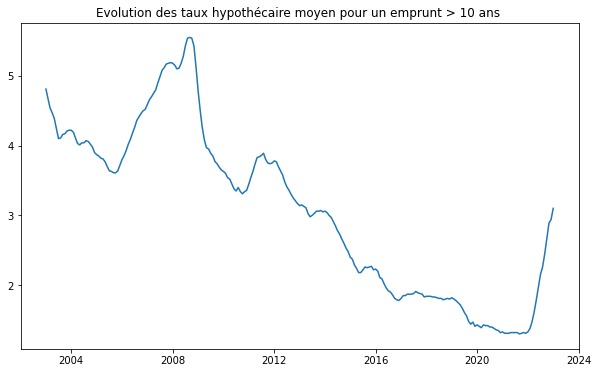

In [17]:
plt.figure(figsize=(10,6))
plt.plot(morgage_rate)
plt.title('Evolution des taux hypothécaire moyen pour un emprunt > 10 ans ');


Sur le graphique ci-dessus, on peut observer que la série de taux hypothécaires européens a dévoilé une évolution remarquable tout au long de la période étudiée. Dès 2003, les taux ont débuté à un niveau relativement élevé, atteignant 4,81 %. Cependant, il est important de noter que cette série n'a pas présenté un caractère stationnaire. En effet, elle a connu une baisse régulière jusqu'à atteindre un creux de 1,78 % en 2016, principalement soutenue par des politiques monétaires accommodantes et des conditions économiques favorables. Par la suite, à partir de 2017, les taux ont progressivement augmenté, reflétant des signes de reprise économique et des pressions inflationnistes. En 2022, les taux ont même connu une augmentation plus significative, atteignant 3,37 %. Cette hausse peut être attribuée à la normalisation graduelle de la politique monétaire et à l'anticipation de taux d'intérêt plus élevés.

In [18]:
# Concaténation des différents taux gouvernementaux avec les taux hypothécaires
df = pd.merge(morgage_rate, yields,left_index=True, right_index=True)
df

rates  Austria  Belgium  Bulgaria  Cyprus  Czech Republic  \
2003-01-01   4.81     4.22     4.28      7.20    5.29            4.10   
2003-02-01   4.67     4.01     4.11      6.93    4.83            3.81   
2003-03-01   4.54     4.03     4.15      6.93    4.83            3.75   
2003-04-01   4.47     4.16     4.29      6.79    4.80            3.92   
2003-05-01   4.39     3.85     3.95      6.78    4.63            3.73   
...           ...      ...      ...       ...     ...             ...   
2022-09-01   2.45     2.46     2.45      1.85    3.70            4.72   
2022-10-01   2.67     2.92     2.84      1.85    4.20            5.52   
2022-11-01   2.89     2.70     2.65      1.85    4.19            5.11   
2022-12-01   2.94     2.74     2.70      1.85    4.20            4.71   
2023-01-01   3.10     2.81     2.79      1.85    4.19            4.47   

            Germany  Denmark  Estonia  Spain  ...  Luxembourg  Latvia  Malta  \
2003-01-01     4.18     4.43      NaN   4.24  ...        3.62    4.62   5.54   
2003-02-01     3.95     4.21      NaN   4.01  ...        3.55    4.77   5.51   
2003-03-01     4.00     4.26      NaN   4.04  ...        3.55    4.99   5.40   
2003-04-01     4.15     4.41      NaN   4.19  ...        3.55    4.99   5.25   
2003-05-01     3.82     4.09      NaN   3.88  ...        3.55    4.95   5.14   
...             ...      ...      ...    ...  ...         ...     ...    ...   
2022-09-01     1.80     2.20     2.93   2.92  ...        2.55    2.96   3.30   
2022-10-01     2.19     2.60     4.07   3.29  ...        2.99    3.81   3.80   
2022-11-01     2.07     2.38     3.75   3.06  ...        2.70    3.74   3.44   
2022-12-01     2.08     2.29     3.46   3.09  ...        2.68    3.50   3.59   
2023-01-01     2.19     2.43     3.79   3.20  ...        2.70    3.70   3.55   

            Netherlands  Poland  Portugal  Romania  Sweden  Slovenia  Slovakia  
2003-01-01         4.19    5.66      4.27      NaN    4.70      6.65      4.98  
2003-02-01         3.97    5.66      4.04      NaN    4.47      6.65      4.92  
2003-03-01         4.01    5.52      4.08      NaN    4.57      6.65      5.01  
2003-04-01         4.23    5.41      4.18      NaN    4.72      6.65      4.90  
2003-05-01         3.91    5.12      3.91      NaN    4.37      6.65      4.72  
...                 ...     ...       ...      ...     ...       ...       ...  
2022-09-01         2.14    6.28      2.89     8.07    2.08      1.70      2.87  
2022-10-01         2.52    7.82      3.26     9.13    2.27      2.51      3.55  
2022-11-01         2.35    7.24      3.02     7.65    2.05      3.56      3.37  
2022-12-01         2.43    6.61      3.10     7.17    1.97      3.52      3.20  
2023-01-01         2.50    6.02      3.13     6.80    2.08      3.25      3.25  

[241 rows x 27 columns]

In [19]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2003-01-01 to 2023-01-01
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rates           241 non-null    float64
 1   Austria         241 non-null    float64
 2   Belgium         241 non-null    float64
 3   Bulgaria        241 non-null    float64
 4   Cyprus          241 non-null    float64
 5   Czech Republic  241 non-null    float64
 6   Germany         241 non-null    float64
 7   Denmark         241 non-null    float64
 8   Estonia         32 non-null     float64
 9   Spain           241 non-null    float64
 10  Finland         241 non-null    float64
 11  France          241 non-null    float64
 12  Greece          240 non-null    float64
 13  Hungary         241 non-null    float64
 14  Ireland         241 non-null    float64
 15  Italy           241 non-null    float64
 16  Lithuania       241 non-null    float64
 17  Luxembourg      

En prenant en compte des caractéristiques similaires entre les pays, nous estimons que la suppression des taux gouvernementaux croates, estoniens, grecs et roumains en raison des valeurs manquantes ne devrait pas compromettre l'analyse globale. En gardant les autres pays qui présentent des caractéristiques comparables, nous pensons que les modèles présentés ne seront pas significativement impactés par cette exclusion. Cette approche permet ainsi de maintenir la cohérence et la validité de notre analyse tout en minimisant l'impact potentiel des données manquantes sur les résultats.

In [20]:
df = df.drop(['Estonia', 'Romania','Greece'], axis = 1)

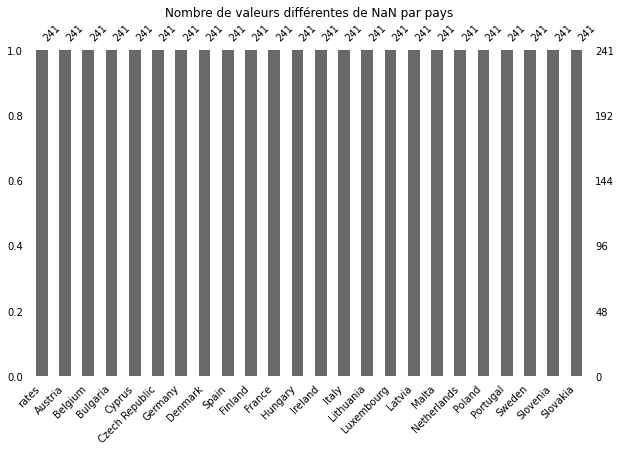

In [21]:
msno.bar(df, figsize=(10,6), fontsize=10)
plt.title('Nombre de valeurs différentes de NaN par pays');

Aucune valeur manquante n'est désormais présentes dans notre jeu de données.

In [22]:
# Plot de l'évolution des yields gouvernementaux ainsi que des taux hypothécaire
fig = px.line(df, x = df.index, y = df.columns, template = 'plotly_dark', title="Evolution des yields gouvernementaux ainsi que des taux hypothécaires")
fig.show()

Dans l'étude des taux d'intérêt de différents pays, nous observons des tendances générales caractérisées par des variations régulières mais relativement stables dans l'ensemble. Cependant, certaines périodes ont été marquées par une volatilité accrue, notamment lors de la crise financière mondiale de 2008-2009 et la crise de la dette souveraine en Europe de 2011-2012. Les taux d'intérêt des pays de la zone euro, tels que l'Allemagne, la France, l'Italie et l'Espagne, présentent souvent une corrélation étroite en raison de l'interdépendance économique et de la politique monétaire commune. Malgré cela, les taux d'intérêt restent relativement stables les uns par rapport aux autres, avec des variations limitées. Des similitudes régionales sont également observées, par exemple entre les pays scandinaves et les pays d'Europe centrale et orientale. Dans le cadre de notre projet, nous aurons l'opportunité de vérifier si nos intuitions et observations concernant les dynamiques des taux d'intérêt se révèlent justes, en examinant de manière plus approfondie les données a l'aide de nos modèles de Machine Learning.

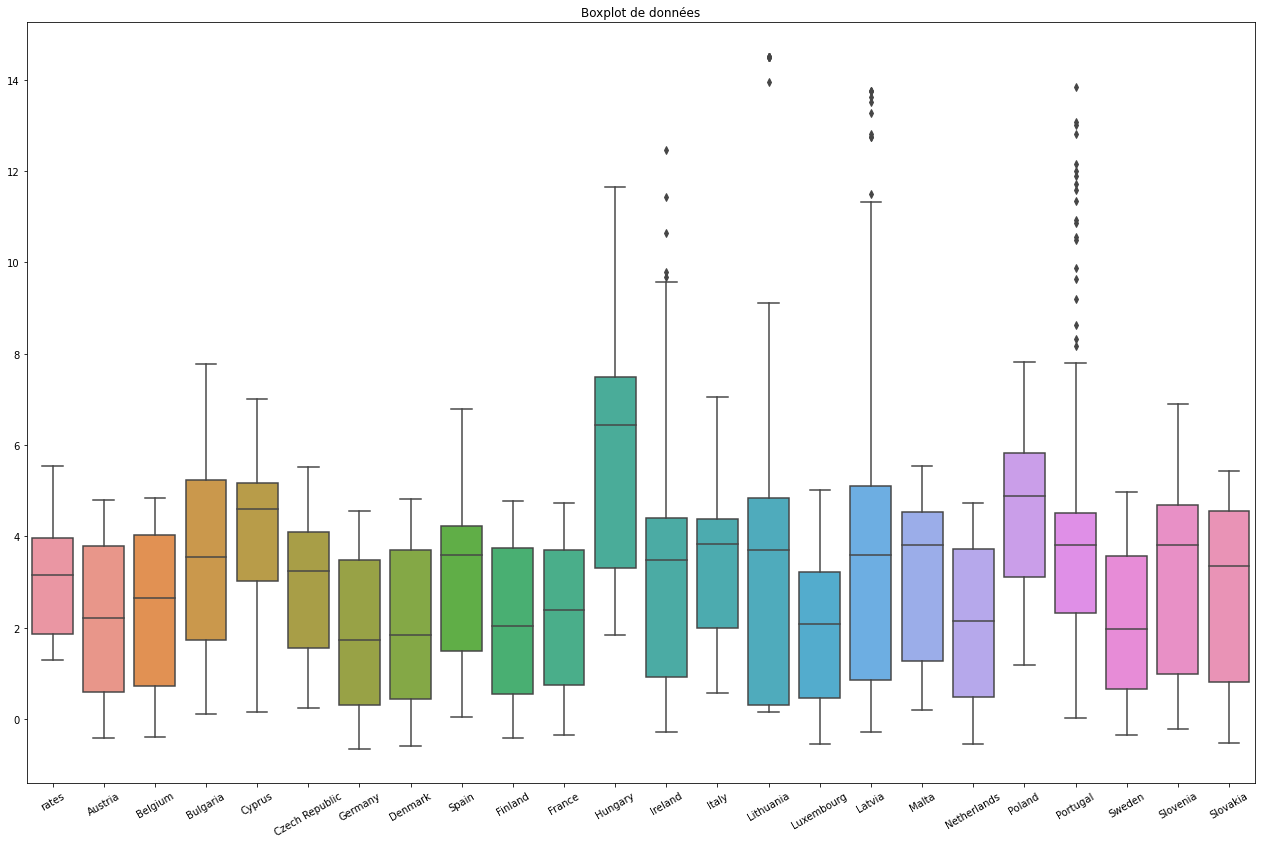

In [23]:
plt.figure(figsize=(22,14))
ax=sns.boxplot(data=df)
plt.title("Boxplot de données")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

 La variabilité dans les données, telle que reflétée par les écarts interquartiles importants observés dans des pays tels que la Lituanie, la Lettonie et la Hongrie, peut être attribuée à des disparités économiques et politiques, ainsi qu'à des besoins de financement spécifiques. Dans le même temps, les pays présentant des quartiles élevés, tels que la Hongrie et la Pologne, sont confrontés à des défis économiques particuliers, tels que des niveaux d'endettement public élevés et des risques accrus.

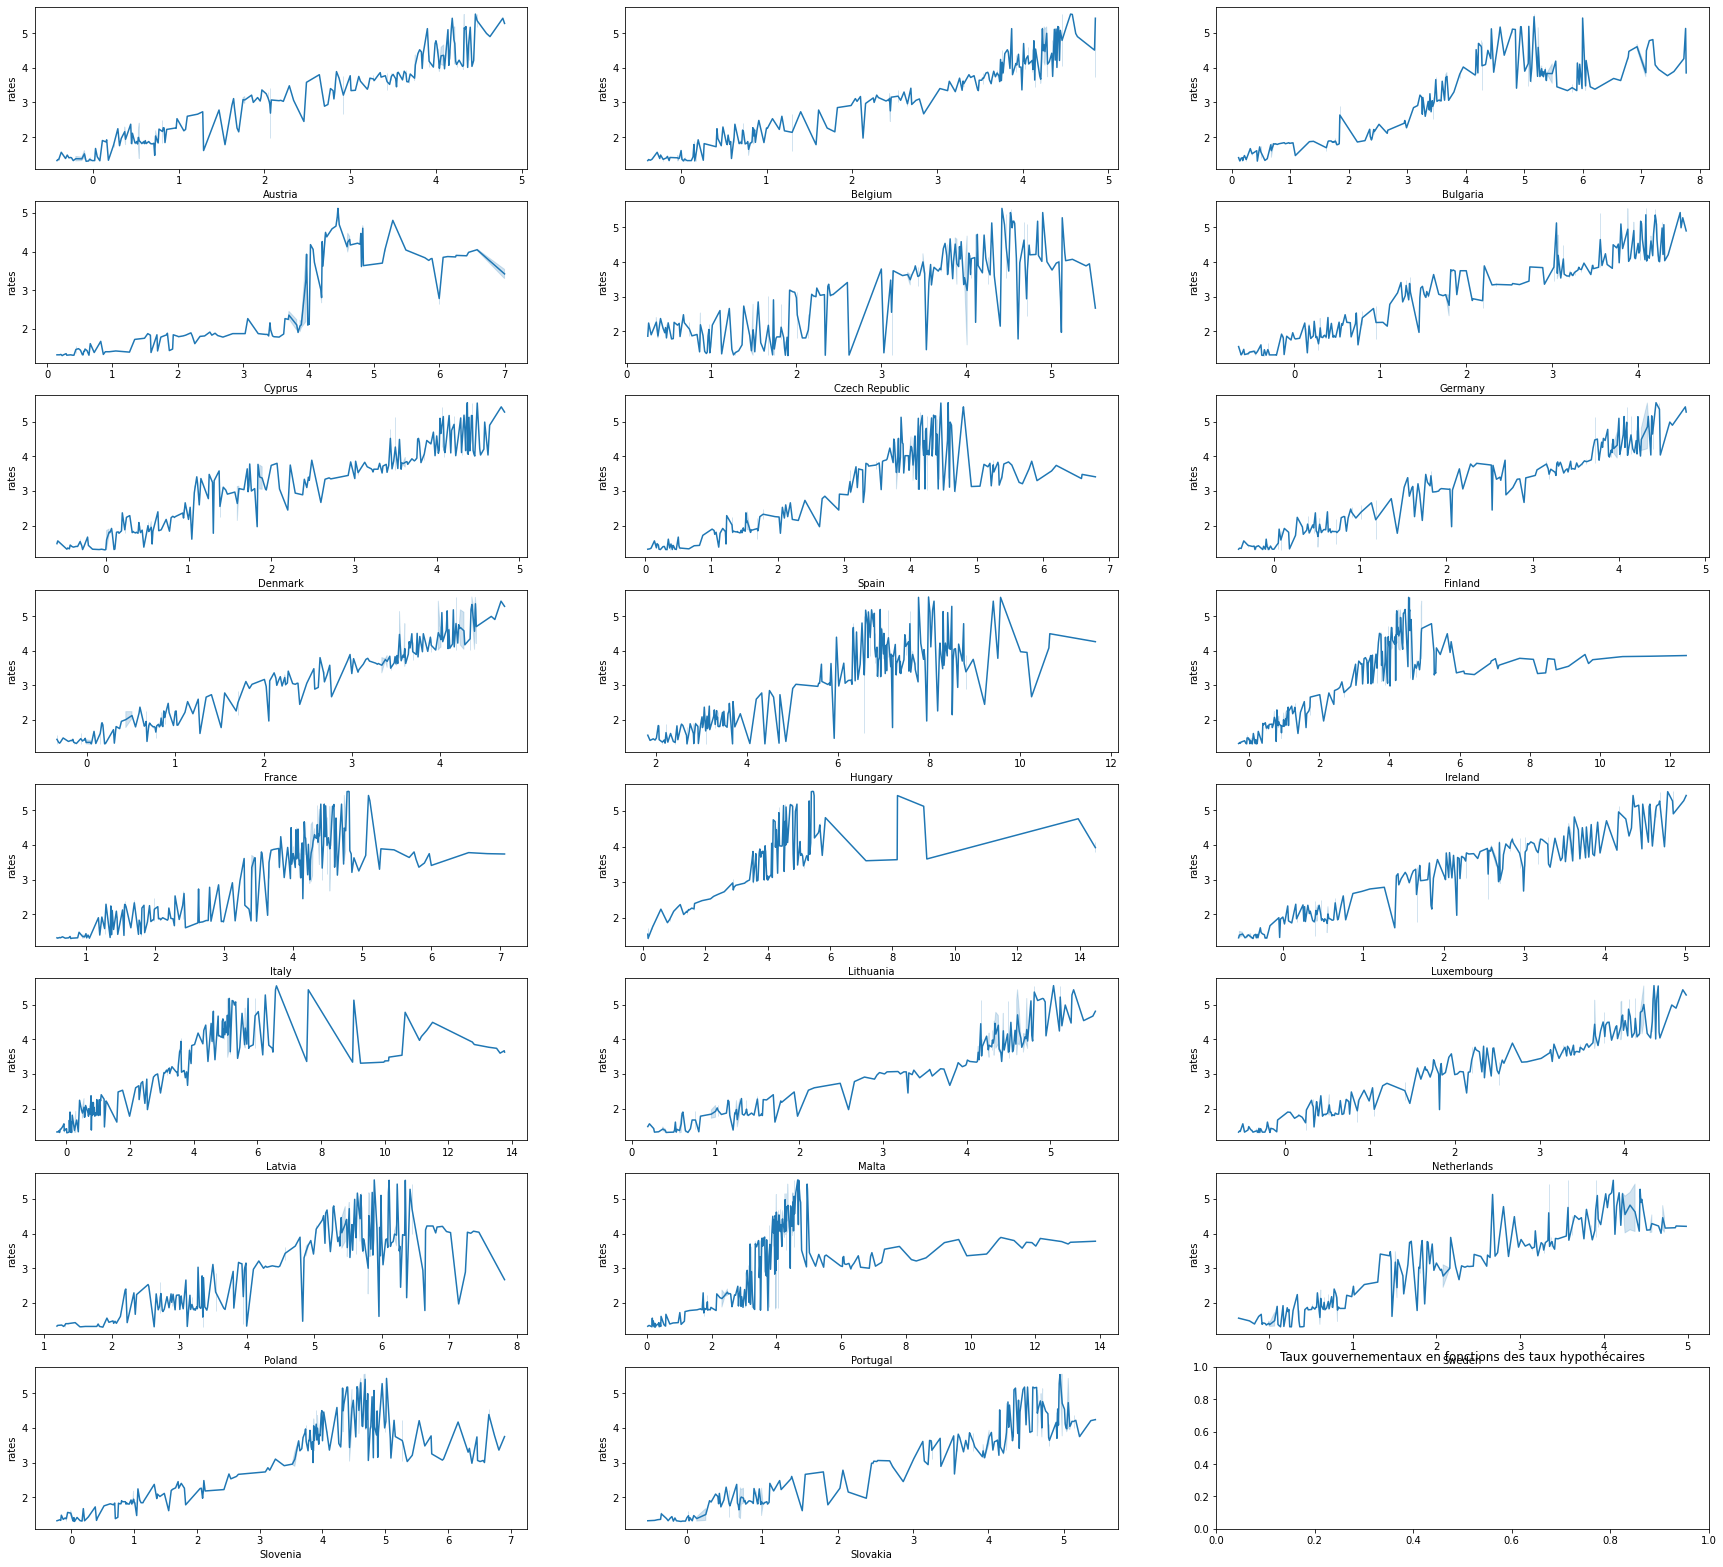

In [24]:
row = 8
col = 3


fig, axes = plt.subplots(row, col, figsize=(30, 28))

for ax,i in zip( axes.ravel(), df.columns[1:]):
    g = sns.lineplot(y = 'rates', x = i, ax= ax, data=df)
plt.title('Taux gouvernementaux en fonctions des taux hypothécaires')
plt.show()

Nous pouvons observer des relations linéaires significatives entre les rendements des obligations des pays et les taux d'intérêt immobilier dans plusieurs pays, notamment la Belgique, l'Autriche, le Danemark, la Finlande, l'Allemagne, la France, le Luxembourg et les Pays-Bas. Cela suggère que les variations des taux d'intérêt immobilier dans ces pays sont étroitement liées aux rendements des obligations. Cependant, nous avons également constaté que certains pays, tels que la Lituanie, le Portugal et la Pologne, ne présentent pas de relation linéaire apparente entre ces deux variables.

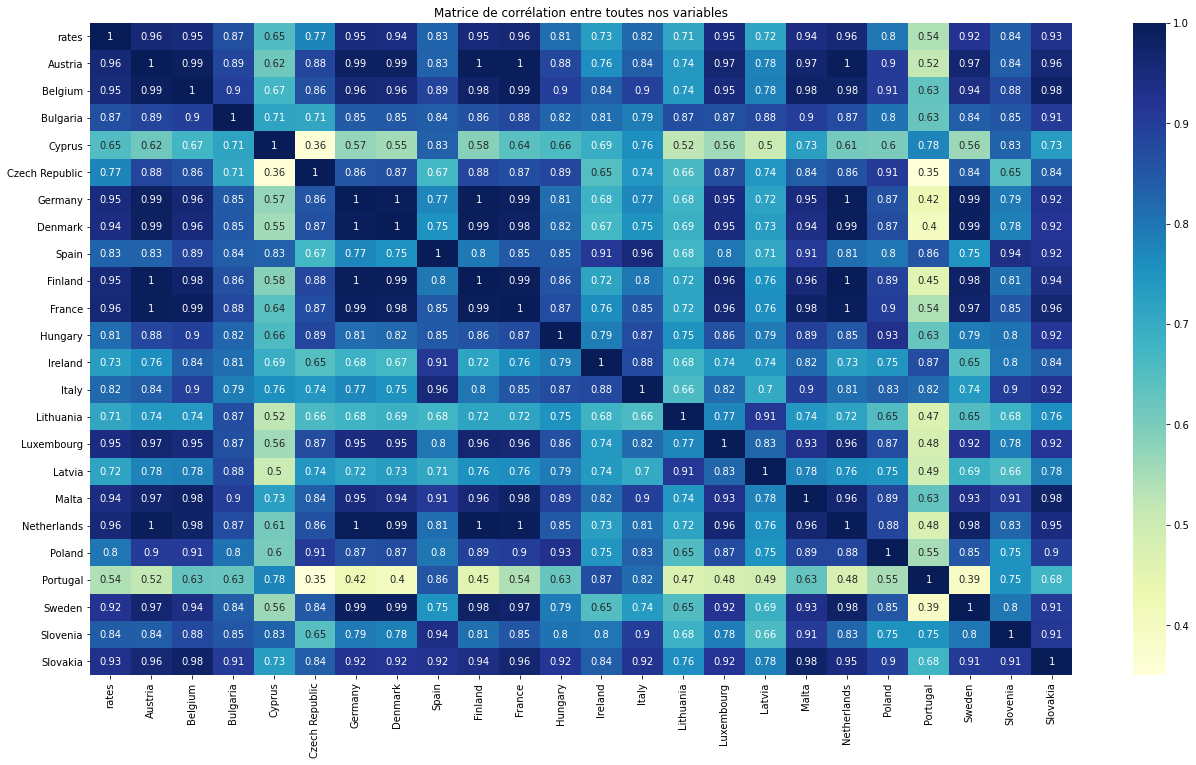

In [25]:
plt.figure(figsize=(22,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title("Matrice de corrélation entre toutes nos variables");


Nous pouvons observer des variations dans la corrélation entre les taux gouvernementaux et les taux d'emprunt moyen des pays européens. Certains pays tels que l'Autriche, la Belgique, la Bulgarie et Chypre montrent une corrélation relativement forte, indiquant une relation étroite entre ces variables. Cela peut être attribué à leur stabilité économique et politique, qui renforce la confiance des investisseurs dans leurs obligations gouvernementales. D'autres pays comme les Pays-Bas, la Pologne et la Suède présentent une corrélation plus faible, ce qui suggère l'influence de facteurs économiques ou politiques supplémentaires. Par exemple, l'indépendance monétaire peut jouer un rôle dans ces pays en dehors de la zone euro. Les conditions économiques nationales, telles que l'inflation et la croissance économique, ainsi que les politiques budgétaires, peuvent également contribuer aux variations de corrélation.

## Modèle Naif: 2 OLS

## Sélection de variables et modélisaiton

De manière très intuitive la relation linéaire entre les taux hypothécaires et les taux d'emprunt à 10 ans des pays, le choix des deux prédicteurs, l'Allemagne et l'Espagne, se justifie. L'Allemagne, en tant que plus grande force économique de l'Europe et reconnue pour sa stabilité économique, est souvent considérée comme une référence dans la zone euro. Son taux gouvernemental et son taux d'emprunt moyen peuvent servir de point de comparaison pour les autres pays. D'un autre côté, l'Espagne représente un pays qui a traversé des difficultés économiques dans le passé, ce qui en fait un bon candidat pour étudier les effets de ces facteurs sur les taux d'emprunt.

In [26]:
df.tail()

rates  Austria  Belgium  Bulgaria  Cyprus  Czech Republic  \
2022-09-01   2.45     2.46     2.45      1.85    3.70            4.72   
2022-10-01   2.67     2.92     2.84      1.85    4.20            5.52   
2022-11-01   2.89     2.70     2.65      1.85    4.19            5.11   
2022-12-01   2.94     2.74     2.70      1.85    4.20            4.71   
2023-01-01   3.10     2.81     2.79      1.85    4.19            4.47   

            Germany  Denmark  Spain  Finland  ...  Lithuania  Luxembourg  \
2022-09-01     1.80     2.20   2.92     2.53  ...       0.16        2.55   
2022-10-01     2.19     2.60   3.29     2.90  ...       0.16        2.99   
2022-11-01     2.07     2.38   3.06     2.69  ...       2.88        2.70   
2022-12-01     2.08     2.29   3.09     2.71  ...       2.88        2.68   
2023-01-01     2.19     2.43   3.20     2.77  ...       2.88        2.70   

            Latvia  Malta  Netherlands  Poland  Portugal  Sweden  Slovenia  \
2022-09-01    2.96   3.30         2.14    6.28      2.89    2.08      1.70   
2022-10-01    3.81   3.80         2.52    7.82      3.26    2.27      2.51   
2022-11-01    3.74   3.44         2.35    7.24      3.02    2.05      3.56   
2022-12-01    3.50   3.59         2.43    6.61      3.10    1.97      3.52   
2023-01-01    3.70   3.55         2.50    6.02      3.13    2.08      3.25   

            Slovakia  
2022-09-01      2.87  
2022-10-01      3.55  
2022-11-01      3.37  
2022-12-01      3.20  
2023-01-01      3.25  

[5 rows x 24 columns]

In [27]:
df[['rates', 'Germany', 'Spain']].head()

rates  Germany  Spain
2003-01-01   4.81     4.18   4.24
2003-02-01   4.67     3.95   4.01
2003-03-01   4.54     4.00   4.04
2003-04-01   4.47     4.15   4.19
2003-05-01   4.39     3.82   3.88

In [28]:
dataset = df.iloc[:-1,1:]
dataset['rates'] = df.rates.shift(-1)
donnee = dataset[['rates', 'Germany', 'Spain']]
donnee.index = df.index[:-1]
donnee.head()

rates  Germany  Spain
2003-01-01   4.67     4.18   4.24
2003-02-01   4.54     3.95   4.01
2003-03-01   4.47     4.00   4.04
2003-04-01   4.39     4.15   4.19
2003-05-01   4.24     3.82   3.88

Afin de tester notre modèle sur des données stationnaires nous avons décidé de travailler également sur les sur l'accroissement des taux.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3, shuffle=False)

In [30]:
y_train.head()

2003-01-01    4.67
2003-02-01    4.54
2003-03-01    4.47
2003-04-01    4.39
2003-05-01    4.24
Name: rates, dtype: float64

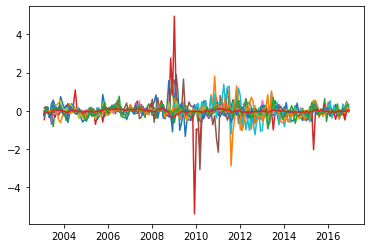

In [31]:
plt.plot(X_train.diff())
plt.plot(y_train.diff());

In [32]:
adfuller(X_train.diff().dropna().iloc[:,10])

(-10.857215434670035,
 1.477163281553663e-19,
 1,
 165,
 {'1%': -3.470616369591229,
  '5%': -2.8792214018977655,
  '10%': -2.57619681359045},
 159.90362766103493)

In [33]:
print("Les p-values de l'accroissement des différents yields sont:",[round(adfuller(X_train.diff().dropna().iloc[:,i])[1], 2) for i in range(0,X_train.shape[1]-1)])


Les p-values de l'accroissement des différents yields sont: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


L'ensemble des p-values étant < au cutoff = 0.05, ceci prouve la stationnarité de l'accroissement des taux.

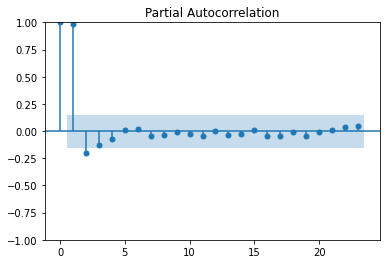

In [34]:
tsaplots.plot_pacf(y_train);

Pour un retard (lag) de 1 et 2, on observe une corrélation significative. Cependant, les valeurs suivantes sont en grande partie non significatives, avec des autocorrélations partielles proches de zéro ou dans l'intervalle de confiance. Dans notre cas, allons choisir des lags de 1 et 2 puisque les autocorrélations partielles pour les autres lags ne semblent pas être significatives.

$Y_{t+1} = \alpha+ \beta_1*Germany_t + \beta_2*Spain_t + \gamma_1 * Y_{t} + \gamma_2 * Y_{t-1}$

In [35]:
X_train_ols = X_train[['Germany', 'Spain']].copy()
y_train_ols = y_train.copy()
X_test_ols = X_test[['Germany', 'Spain']].copy()
y_test_ols = y_test.copy()
X_train_ols['y_lagged_1'] = y_train_ols.shift(1)
X_train_ols['y_lagged_2'] = y_train_ols.shift(2)

X_test_ols['y_lagged_1'] = y_test_ols.shift(1)
X_test_ols['y_lagged_2'] = y_test_ols.shift(2)

X_train_ols = X_train_ols.dropna()
y_train_ols = y_train_ols.iloc[2:]

X_train_ols.head()

Germany  Spain  y_lagged_1  y_lagged_2
2003-03-01     4.00   4.04        4.54        4.67
2003-04-01     4.15   4.19        4.47        4.54
2003-05-01     3.82   3.88        4.39        4.47
2003-06-01     3.62   3.69        4.24        4.39
2003-07-01     3.97   4.03        4.10        4.24

In [36]:
y_train_ols.head()

2003-03-01    4.47
2003-04-01    4.39
2003-05-01    4.24
2003-06-01    4.10
2003-07-01    4.11
Name: rates, dtype: float64

In [37]:
y_train_ols

2003-03-01    4.47
2003-04-01    4.39
2003-05-01    4.24
2003-06-01    4.10
2003-07-01    4.11
              ... 
2016-08-01    1.86
2016-09-01    1.81
2016-10-01    1.79
2016-11-01    1.78
2016-12-01    1.81
Name: rates, Length: 166, dtype: float64

In [38]:
model = sm.OLS(y_train_ols, X_train_ols).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  rates   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.582e+05
Date:                Mon, 15 May 2023   Prob (F-statistic):                   1.70e-318
Time:                        03:11:03   Log-Likelihood:                          299.30
No. Observations:                 166   AIC:                                     -590.6
Df Residuals:                     162   BIC:                                     -578.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Notre modèle montre un coefficient de détermination (R²) de 1.000, ce qui signifie que les variables explicatives expliquent environ 100% de la variation des taux. L'ajustement du R² est de 1.000, ce qui tient compte du nombre de variables et d'observations, de ce fait, en tout et pour tout, notre modèle arrive a plutot bien reproduire la variance inhérente a nos données. Toutefois étant donnée le score parfais, cela pourrait réveler de l'overfitting au sujet de notre modèle. L'analyse de la significativité globale du modèle révèle une F-statistic de  3.582e+05 et une probabilité associée très proche de zéro, indiquant une forte significativité statistique de nos variables par rapport au modèle réduit a l'intercepte. En ce qui concerne les coefficients, nous observons que Germany, y_lagged_1 et 2 sont statistiquement significatif tandis que Spain ne l'est pas avec un niveau de confiance de 95%. Pour finir, en ce qui concerne les hypothèses statistiques, les résidus ne suivent pas une distribution normale, comme le montre la statistique de Jarque-Bera (JB). Dans l'ensemble, notre modèle semble fournir des indications tout de même pertinentes pour comprendre et prédire les taux gouvernementaux. Nous allons maintenant approfondir l'étude des résidus de notre modèle.

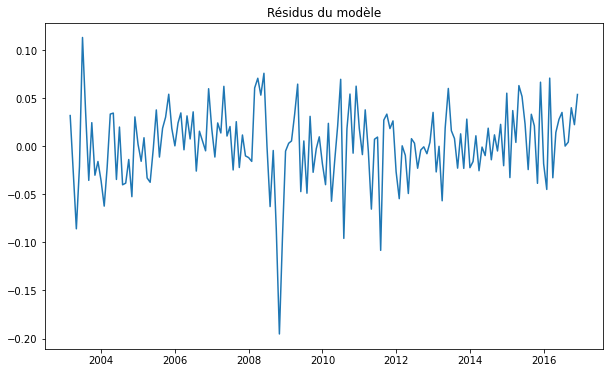

In [39]:
plt.figure(figsize=(10,6))
plt.plot(model.resid)
plt.title("Résidus du modèle");

In [40]:
adfuller(model.resid)[:2] #

(-6.230048181552613, 4.9789192803833207e-08)

In [41]:
stats.jarque_bera(model.resid)

SignificanceResult(statistic=85.56668590343467, pvalue=2.6268195430308767e-19)

Après avoir estimé notre modèle, nous avons procédé à des tests de stationnarité et de normalité des résidus. Le test de Jarque-Bera sur les résidus a révélé une non-normalité significative (p-value proche de 0), ce qui indique une violation de l'hypothèse de normalité dans la régression linéaire. Cependant, il est important de noter que l'hypothèse de normalité des résidus n'est pas une condition essentielle pour la régression linéaire elle-même, mais plutôt pour certains tests statistiques et l'estimation des intervalles de confiance des coefficients.

Malgré la non-normalité des résidus, nous avons constaté que les résidus étaient stationnaires et ne présentaient pas d'autocorrélation, comme le confirment les tests d'Augmented Dickey-Fuller. Cela indique que les erreurs de notre modèle ne présentent pas de tendance systématique dans le temps.

Il convient de souligner que notre modèle présente des difficultés à capturer la crise de 2008/2009, mais parvient à saisir relativement bien la crise liée à la COVID malgré les fluctuations du marché. Cette observation suggère une réaction différente du marché lors de ces deux crises, avec une réactivité moins rapide et moins prononcée en 2009 qu'en 2020/2021. Dans la perspective d'une prédiction, il conviendra de garder en tête que notre modèle prédit plutot bien hors période de crise ou nous avons pu voir que selon la conjecture le modèle réussissait plus ou moins a capter certaines tendances.

In [42]:
X_test_ols.head()

Germany  Spain  y_lagged_1  y_lagged_2
2017-01-01     0.25   1.46         NaN         NaN
2017-02-01     0.26   1.70        1.85         NaN
2017-03-01     0.35   1.72        1.85        1.85
2017-04-01     0.22   1.61        1.87        1.85
2017-05-01     0.34   1.57        1.87        1.87

In [43]:
y_test_ols.head()

2017-01-01    1.85
2017-02-01    1.85
2017-03-01    1.87
2017-04-01    1.87
2017-05-01    1.87
Name: rates, dtype: float64

In [44]:
y_pred_ols = X_test_ols @ np.array(model.params).reshape(len(X_test_ols.columns),1)

In [45]:
y_pred_train_ols = X_train_ols@ np.array(model.params).reshape(len(X_train_ols.columns),1)

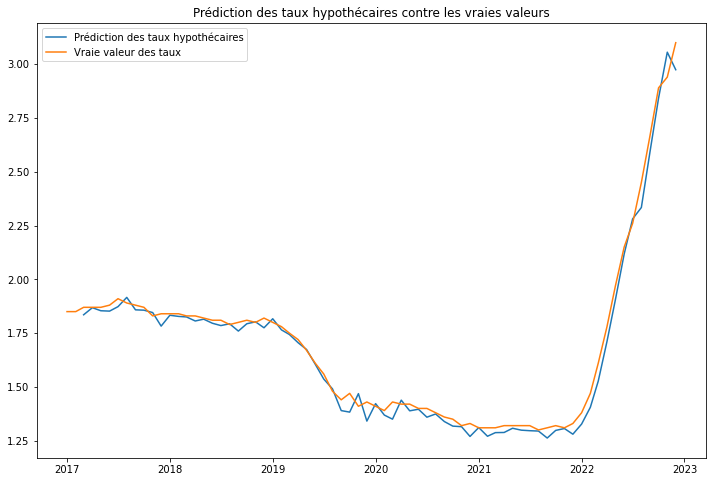

In [46]:
plt.figure(figsize=(12,8))
plt.plot(y_pred_ols)
plt.plot(y_test_ols)
plt.legend(['Prédiction des taux hypothécaires','Vraie valeur des taux']);
plt.title("Prédiction des taux hypothécaires contre les vraies valeurs");

Une fois que nous avons procédé à l'estimation du modèle sur l'ensemble des données d'entraînement, nous avons procédé à l'évaluation de sa performance en utilisant les données de test. L'objectif était de mesurer l'aptitude du modèle à généraliser ses prédictions sur de nouvelles données. En utilisant les caractéristiques des données de test comme variables d'entrée, nous avons utilisé le modèle estimé pour faire des prédictions sur les variables cibles correspondantes. En comparant ces prédictions avec les valeurs réelles des variables cibles dans l'ensemble de données de test, nous avons pu évaluer la précision et la performance du modèle dans un contexte hors échantillon. Cette évaluation nous fournit une indication de la capacité du modèle à s'adapter à de nouvelles données et à fournir des prédictions fiables dans des situations réelles.

Après avoir observé les écarts entre les valeurs prédites et les valeurs réelles, nous avons cherché à quantifier ces déviations en utilisant des métriques telles que l'erreur quadratique moyenne (MSE) et la racine carrée de l'erreur quadratique moyenne (RMSE). Le MSE mesure la moyenne des écarts quadratiques entre les valeurs prédites et les valeurs réelles, donnant ainsi une mesure de la magnitude moyenne des erreurs de prédiction. Le RMSE, quant à lui, calcule la racine carrée du MSE, ce qui nous donne une mesure de l'erreur de prédiction moyenne dans la même unité que la variable cible. En utilisant ces métriques, nous pouvons évaluer la précision de notre modèle en termes d'erreurs de prédiction et obtenir une meilleure compréhension de ses performances.

In [47]:
print('MSE train set:')
print(round(mean_squared_error(y_train[2:], y_pred_train_ols.dropna()), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[2:], y_pred_ols.dropna()), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[2:], y_pred_train_ols.dropna(), squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[2:], y_pred_ols.dropna(), squared =False), 6))

MSE train set:
0.00159
MSE test set:
0.001947
RMSE train set:
0.039878
RMSE test set:
0.044124


Sur l'ensemble de test, le RMSE est de 0.044124 contre 0.039878, ce qui indique une légère augmentation de l'erreur de prédiction par rapport à l'ensemble d'entraînement. Quant au MSE est de 0.001947 contre 0.00159, ce qui indique également une légère augmentation de l'erreur de prédiction par rapport à l'ensemble d'entraînement. Dans l'ensemble nous pouvons observer une légère augmentation sur l'ensemble de test ce qui nous laisse entrevoir que le modèle se généralise plutot bien sans trop overfitter.

# OLS on diff

$\Delta Y_{t+1} = \alpha+ \beta_1*Germany_t + \beta_2*Spain_t + \gamma_1 * \Delta Y_{t} + \gamma_2 * \Delta Y_{t-1}$

In [48]:
X_train_diff_ols = X_train[['Germany', 'Spain']].copy().diff()
y_train_diff_ols = y_train.copy().diff()
X_test_diff_ols = X_test[['Germany', 'Spain']].copy().diff()
y_test_diff_ols = y_test.copy().diff()
X_train_diff_ols['y_lagged_1'] = y_train_diff_ols.shift(1)
X_train_diff_ols['y_lagged_2'] = y_train_diff_ols.shift(2)

X_test_diff_ols['y_lagged_1'] = y_test_diff_ols.shift(1)
X_test_diff_ols['y_lagged_2'] = y_test_diff_ols.shift(2)

X_train_diff_ols = X_train_diff_ols.dropna()
y_train_diff_ols = y_train_diff_ols.iloc[3:]

X_train_diff_ols.head()

Germany  Spain  y_lagged_1  y_lagged_2
2003-04-01     0.15   0.15       -0.07       -0.13
2003-05-01    -0.33  -0.31       -0.08       -0.07
2003-06-01    -0.20  -0.19       -0.15       -0.08
2003-07-01     0.35   0.34       -0.14       -0.15
2003-08-01     0.16   0.16        0.01       -0.14

In [49]:
y_train_diff_ols.head()

2003-04-01   -0.08
2003-05-01   -0.15
2003-06-01   -0.14
2003-07-01    0.01
2003-08-01    0.05
Name: rates, dtype: float64

In [50]:
model_diff_ols = sm.OLS(y_train_diff_ols, X_train_diff_ols).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  rates   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.582e+05
Date:                Mon, 15 May 2023   Prob (F-statistic):                   1.70e-318
Time:                        03:11:04   Log-Likelihood:                          299.30
No. Observations:                 166   AIC:                                     -590.6
Df Residuals:                     162   BIC:                                     -578.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

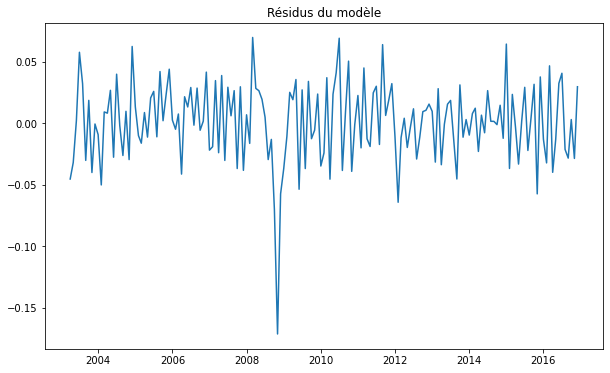

In [51]:
plt.figure(figsize=(10,6))
plt.plot(model_diff_ols.resid)
plt.title("Résidus du modèle");

In [52]:
adfuller(model_diff_ols.resid)[:2]

(-6.522996875732152, 1.0310036170510094e-08)

In [53]:
stats.jarque_bera(model_diff_ols.resid)

SignificanceResult(statistic=117.75544347165193, pvalue=2.689864127242333e-26)

In [54]:
y_pred_diff_ols = X_test_diff_ols @ np.array(model_diff_ols.params).reshape(len(X_test_diff_ols.columns),1)

In [55]:
y_pred_train_diff_ols = X_train_diff_ols@ np.array(model_diff_ols.params).reshape(len(X_train_diff_ols.columns),1)

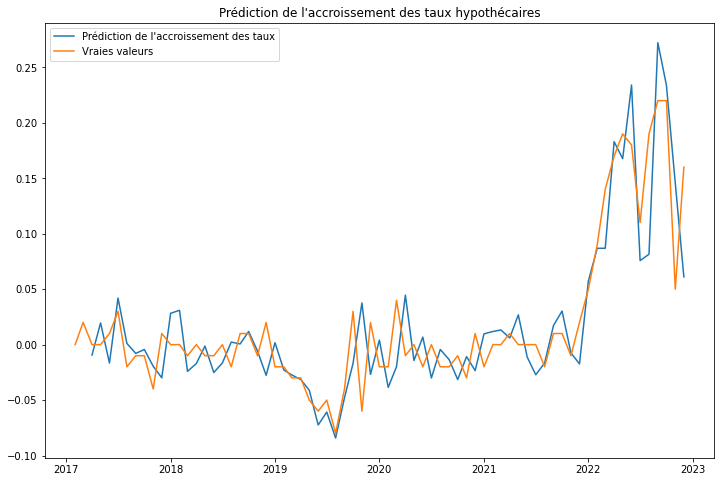

In [56]:
plt.figure(figsize=(12,8))
plt.plot(y_pred_diff_ols)
plt.plot(y_test_diff_ols)
plt.legend(["Prédiction de l'accroissement des taux", "Vraies valeurs"]);
plt.title("Prédiction de l'accroissement des taux hypothécaires");

In [57]:
print('MSE train set:')
print(round(mean_squared_error(y_train[3:], y_pred_train_diff_ols.dropna()[0]+ y_train[2:-1].values), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[3:], y_pred_diff_ols.dropna()[0]+ y_test[2:-1].values), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[3:], y_pred_train_diff_ols.dropna()[0]+ y_train[2:-1].values, squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[3:], y_pred_diff_ols.dropna()[0]+ y_test[2:-1].values, squared=False), 6))

MSE train set:
0.001024
MSE test set:
0.001186
RMSE train set:
0.032001
RMSE test set:
0.034438



Après avoir modifié notre modèle pour prédire les variations de taux plutôt que les taux directs, nous avons obtenu de nouveaux résultats similaires si ce n'est sur les métriques d'erreur donc nous nous contenterons de commenter les erreurs. Nous pouvons remarquer que le passage par la prédiction des taux d'accroissement nous a permis de gagner en précision sans toutefois tomber dans l'overfitting. L'étude de l'OLS nous a servi de base afin de nous donner une direction sur la création de features pertinente et pour avoir un benchmark.

# Random forest

Dans le but d'améliorer les performances de notre modèle, nous avons opté pour une approche plus complexe en utilisant un Random Forest. Ce modèle tient compte des interactions entre les différentes variables explicatives, y compris celles qui sont non linéaires. Contrairement à notre précédent modèle, nous incluons cette fois-ci toutes les variables disponibles ainsi qu'un décalage d'un et de deux pas. Cette approche permet d'explorer plus en profondeur les relations entre les variables et d'améliorer la capacité de prédiction du modèle.

In [58]:
X_rf_train_raw = X_train.copy()
y_rf_train_raw = y_train.copy()

In [59]:
X_rf_train_raw['y_lagged_1'] = y_rf_train_raw.shift(1)
X_rf_train_raw['y_lagged_2'] = y_rf_train_raw.shift(2)
X_rf_train_raw = X_rf_train_raw.dropna()
y_rf_train_raw = y_rf_train_raw.iloc[2:]
X_rf_train_raw

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-03-01     4.03     4.15      6.93    4.83            3.75     4.00   
2003-04-01     4.16     4.29      6.79    4.80            3.92     4.15   
2003-05-01     3.85     3.95      6.78    4.63            3.73     3.82   
2003-06-01     3.76     3.74      6.78    4.63            3.49     3.62   
2003-07-01     4.06     4.06      5.95    4.59            4.06     3.97   
...             ...      ...       ...     ...             ...      ...   
2016-08-01     0.11     0.15      2.28    3.84            0.29    -0.13   
2016-09-01     0.15     0.18      2.15    3.62            0.25    -0.09   
2016-10-01     0.24     0.27      1.84    3.39            0.37     0.00   
2016-11-01     0.49     0.57      1.82    3.47            0.55     0.19   
2016-12-01     0.53     0.61      1.80    3.55            0.53     0.25   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2003-03-01     4.26   4.04     4.09    4.10  ...    4.99   5.40         4.01   
2003-04-01     4.41   4.19     4.23    4.22  ...    4.99   5.25         4.23   
2003-05-01     4.09   3.88     3.91    3.89  ...    4.95   5.14         3.91   
2003-06-01     3.85   3.69     3.70    3.69  ...    4.89   5.11         3.72   
2003-07-01     4.17   4.03     4.01    4.01  ...    4.78   4.95         4.04   
...             ...    ...      ...     ...  ...     ...    ...          ...   
2016-08-01     0.04   1.01     0.06    0.15  ...    0.12   0.61         0.03   
2016-09-01     0.01   1.04     0.08    0.18  ...    0.10   0.60         0.06   
2016-10-01     0.13   1.07     0.17    0.33  ...    0.19   0.59         0.16   
2016-11-01     0.32   1.43     0.41    0.67  ...    0.56   0.84         0.39   
2016-12-01     0.39   1.44     0.46    0.75  ...    0.90   0.82         0.44   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2003-03-01    5.52      4.08    4.57      6.65      5.01        4.54   
2003-04-01    5.41      4.18    4.72      6.65      4.90        4.47   
2003-05-01    5.12      3.91    4.37      6.65      4.72        4.39   
2003-06-01    5.03      3.77    4.20      6.65      4.70        4.24   
2003-07-01    5.37      4.10    4.51      6.65      4.80        4.10   
...            ...       ...     ...       ...       ...         ...   
2016-08-01    2.71      2.91    0.10      0.80      0.30        1.90   
2016-09-01    2.85      3.26    0.22      0.75      0.32        1.86   
2016-10-01    3.01      3.33    0.24      0.62      0.42        1.81   
2016-11-01    3.41      3.51    0.43      0.89      0.72        1.79   
2016-12-01    3.54      3.74    0.61      0.96      1.01        1.78   

            y_lagged_2  
2003-03-01        4.67  
2003-04-01        4.54  
2003-05-01        4.47  
2003-06-01        4.39  
2003-07-01        4.24  
...                ...  
2016-08-01        1.92  
2016-09-01        1.90  
2016-10-01        1.86  
2016-11-01        1.81  
2016-12-01        1.79  

[166 rows x 25 columns]

In [60]:
X_rf_train_diff = X_train.copy().diff()
y_rf_train_diff = y_train.copy().diff()

In [61]:
X_rf_train_diff['y_lagged_1'] = y_rf_train_diff.shift(1)
X_rf_train_diff['y_lagged_2'] = y_rf_train_diff.shift(2)
X_rf_train_diff =X_rf_train_diff.dropna()
y_rf_train_diff = y_rf_train_diff.iloc[3:]
X_rf_train_diff

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-04-01     0.13     0.14     -0.14   -0.03            0.17     0.15   
2003-05-01    -0.31    -0.34     -0.01   -0.17           -0.19    -0.33   
2003-06-01    -0.09    -0.21      0.00    0.00           -0.24    -0.20   
2003-07-01     0.30     0.32     -0.83   -0.04            0.57     0.35   
2003-08-01     0.16     0.16     -0.04    0.00            0.17     0.16   
...             ...      ...       ...     ...             ...      ...   
2016-08-01    -0.05    -0.05     -0.11   -0.03           -0.08     0.02   
2016-09-01     0.04     0.03     -0.13   -0.22           -0.04     0.04   
2016-10-01     0.09     0.09     -0.31   -0.23            0.12     0.09   
2016-11-01     0.25     0.30     -0.02    0.08            0.18     0.19   
2016-12-01     0.04     0.04     -0.02    0.08           -0.02     0.06   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2003-04-01     0.15   0.15     0.14    0.12  ...    0.00  -0.15         0.22   
2003-05-01    -0.32  -0.31    -0.32   -0.33  ...   -0.04  -0.11        -0.32   
2003-06-01    -0.24  -0.19    -0.21   -0.20  ...   -0.06  -0.03        -0.19   
2003-07-01     0.32   0.34     0.31    0.32  ...   -0.11  -0.16         0.32   
2003-08-01     0.18   0.16     0.17    0.15  ...    0.02  -0.17         0.14   
...             ...    ...      ...     ...  ...     ...    ...          ...   
2016-08-01    -0.03  -0.16    -0.06   -0.02  ...   -0.18  -0.15        -0.03   
2016-09-01    -0.03   0.03     0.02    0.03  ...   -0.02  -0.01         0.03   
2016-10-01     0.12   0.03     0.09    0.15  ...    0.09  -0.01         0.10   
2016-11-01     0.19   0.36     0.24    0.34  ...    0.37   0.25         0.23   
2016-12-01     0.07   0.01     0.05    0.08  ...    0.34  -0.02         0.05   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2003-04-01   -0.11      0.10    0.15      0.00     -0.11       -0.07   
2003-05-01   -0.29     -0.27   -0.35      0.00     -0.18       -0.08   
2003-06-01   -0.09     -0.14   -0.17      0.00     -0.02       -0.15   
2003-07-01    0.34      0.33    0.31      0.00      0.10       -0.14   
2003-08-01    0.24      0.16    0.19      0.00      0.12        0.01   
...            ...       ...     ...       ...       ...         ...   
2016-08-01   -0.18     -0.15   -0.07     -0.15     -0.19       -0.02   
2016-09-01    0.14      0.35    0.12     -0.05      0.02       -0.04   
2016-10-01    0.16      0.07    0.02     -0.13      0.10       -0.05   
2016-11-01    0.40      0.18    0.19      0.27      0.30       -0.02   
2016-12-01    0.13      0.23    0.18      0.07      0.29       -0.01   

            y_lagged_2  
2003-04-01       -0.13  
2003-05-01       -0.07  
2003-06-01       -0.08  
2003-07-01       -0.15  
2003-08-01       -0.14  
...                ...  
2016-08-01       -0.04  
2016-09-01       -0.02  
2016-10-01       -0.04  
2016-11-01       -0.05  
2016-12-01       -0.02  

[165 rows x 25 columns]

Afin de selectionner les hyperparamètres optimaux (nombre d'estimateurs et pruning via max_depth) nous avons opté pour l'utilisation d'un grid-search.

In [62]:
param_grid = {
    'n_estimators': [*range(10, 160, 10)],
    'max_depth': [3, 5, 10],
}

rf = RandomForestRegressor(random_state=42)

grid_search_raw = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_raw.fit(X_rf_train_raw, y_rf_train_raw)

grid_search_diff = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_diff.fit(X_rf_train_diff, y_rf_train_diff)

rf_best_raw = RandomForestRegressor(**grid_search_raw.best_params_, random_state=42)
rf_best_raw.fit(X_rf_train_raw, y_rf_train_raw)

rf_best_diff = RandomForestRegressor(**grid_search_diff.best_params_, random_state=42)
rf_best_diff.fit(X_rf_train_diff, y_rf_train_diff)

RandomForestRegressor(max_depth=10, random_state=42)

In [63]:
X_rf_test_raw = X_test.copy()
y_rf_test_raw = y_test.copy()
X_rf_test_raw['y_lagged_1'] = y_rf_test_raw.shift(1)
X_rf_test_raw['y_lagged_2'] = y_rf_test_raw.shift(2)
X_rf_test_raw = X_rf_test_raw.dropna()
y_rf_test_raw = y_rf_test_raw.iloc[2:]
X_rf_test_raw.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2017-03-01     0.59     0.87      1.73    3.34            0.87     0.35   
2017-04-01     0.49     0.78      1.78    3.23            0.96     0.22   
2017-05-01     0.65     0.77      1.74    3.03            0.74     0.34   
2017-06-01     0.55     0.62      1.70    2.84            0.77     0.25   
2017-07-01     0.73     0.83      1.65    2.57            0.90     0.46   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2017-03-01     0.19   1.72     0.51    1.02  ...    0.94   1.55         0.48   
2017-04-01     0.55   1.61     0.38    0.88  ...    0.92   1.43         0.50   
2017-05-01     0.64   1.57     0.49    0.81  ...    0.88   1.37         0.59   
2017-06-01     0.53   1.45     0.56    0.66  ...    0.85   1.25         0.50   
2017-07-01     0.67   1.60     0.76    0.84  ...    0.98   1.36         0.69   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2017-03-01    3.66      3.99    0.69      0.99      1.09        1.85   
2017-04-01    3.42      3.77    0.57      1.00      1.06        1.87   
2017-05-01    3.35      3.29    0.56      0.98      1.03        1.87   
2017-06-01    3.19      2.97    0.46      0.86      0.86        1.87   
2017-07-01    3.30      3.02    0.66      1.15      0.93        1.88   

            y_lagged_2  
2017-03-01        1.85  
2017-04-01        1.85  
2017-05-01        1.87  
2017-06-01        1.87  
2017-07-01        1.87  

[5 rows x 25 columns]

In [64]:
X_rf_test_diff = X_test.copy().diff()
y_rf_test_diff = y_test.copy().diff()
X_rf_test_diff['y_lagged_1'] = y_rf_test_diff.shift(1)
X_rf_test_diff['y_lagged_2'] = y_rf_test_diff.shift(2)
X_rf_test_diff = X_rf_test_diff.dropna()
y_rf_test_diff = y_rf_test_diff.iloc[3:]
X_rf_test_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2017-04-01    -0.10    -0.09      0.05   -0.11            0.09    -0.13   
2017-05-01     0.16    -0.01     -0.04   -0.20           -0.22     0.12   
2017-06-01    -0.10    -0.15     -0.04   -0.19            0.03    -0.09   
2017-07-01     0.18     0.21     -0.05   -0.27            0.13     0.21   
2017-08-01    -0.12    -0.10      0.05   -0.08           -0.07    -0.11   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2017-04-01     0.36  -0.11    -0.13   -0.14  ...   -0.02  -0.12         0.02   
2017-05-01     0.09  -0.04     0.11   -0.07  ...   -0.04  -0.06         0.09   
2017-06-01    -0.11  -0.12     0.07   -0.15  ...   -0.03  -0.12        -0.09   
2017-07-01     0.14   0.15     0.20    0.18  ...    0.13   0.11         0.19   
2017-08-01    -0.12  -0.12    -0.11   -0.13  ...   -0.13  -0.13        -0.15   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2017-04-01   -0.24     -0.22   -0.12      0.01     -0.03        0.02   
2017-05-01   -0.07     -0.48   -0.01     -0.02     -0.03        0.00   
2017-06-01   -0.16     -0.32   -0.10     -0.12     -0.17        0.00   
2017-07-01    0.11      0.05    0.20      0.29      0.07        0.01   
2017-08-01    0.03     -0.19   -0.03     -0.06     -0.10        0.03   

            y_lagged_2  
2017-04-01        0.00  
2017-05-01        0.02  
2017-06-01        0.00  
2017-07-01        0.00  
2017-08-01        0.01  

[5 rows x 25 columns]

In [65]:
predictions_diff_rf_test = rf_best_diff.predict(X_rf_test_diff)
predictions_raw_rf_test = rf_best_raw.predict(X_rf_test_raw)

predictions_diff_rf_train = rf_best_diff.predict(X_rf_train_diff)
predictions_raw_rf_train = rf_best_raw.predict(X_rf_train_raw)

In [66]:
print('Statistics Diff')
print('MSE train set:')
print(round(mean_squared_error(y_train[3:], predictions_diff_rf_train+ y_train[2:-1].values), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[3:], predictions_diff_rf_test+ y_test[2:-1].values), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[3:], predictions_diff_rf_train+ y_train[2:-1].values, squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[3:], predictions_diff_rf_test+ y_test[2:-1].values, squared=False), 6))

Statistics Diff
MSE train set:
0.000247
MSE test set:
0.002158
RMSE train set:
0.015705
RMSE test set:
0.046455


In [67]:
print('Statistics Raw')
print('MSE train set:')
print(round(mean_squared_error(y_train[2:], predictions_raw_rf_train), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[2:], predictions_raw_rf_test), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[2:], predictions_raw_rf_train, squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[2:], predictions_raw_rf_test, squared=False), 6))

Statistics Raw
MSE train set:
0.000988
MSE test set:
0.166366
RMSE train set:
0.031435
RMSE test set:
0.40788


Encore une fois, notre modèle performe mieux sur les données stationnaires. De plus, l'augmentation significative entre les données d'entrainement et de test nous laisse penser qu'il n'y a pas d'overfitting. Cependant, il est a noter que même sur les stationnaire, notre modèle a du mal a généraliser ses performances sur de nouvelles observations.

L'un des avantages du Random Forest est sa capacité a mettre en avant les differentes les variables par niveau d'importance. Nous allons utiliser cette caractéristique des Random Forest afin d'en apprendre plus sur nos données.

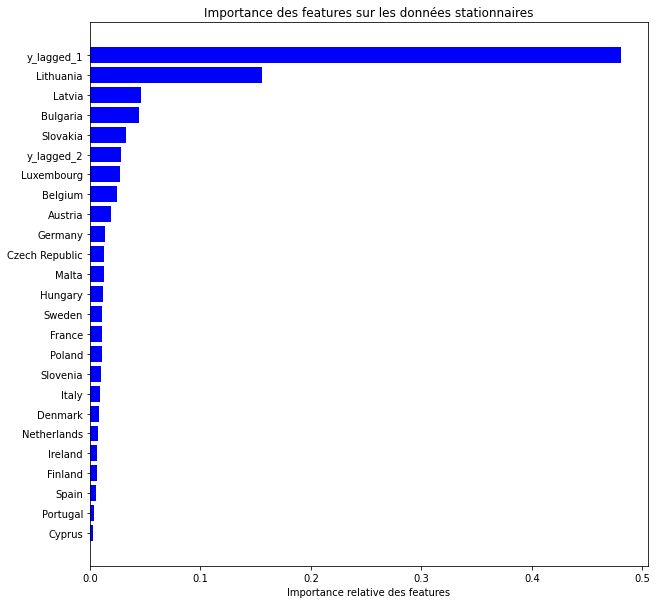

In [68]:
indices = np.argsort(rf_best_diff.feature_importances_)

plt.figure(figsize=(10,10))
plt.title('Importance des features sur les données stationnaires')
plt.barh(range(len(indices)), rf_best_diff.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_rf_train_diff.columns[i] for i in indices])
plt.xlabel('Importance relative des features')
plt.show()

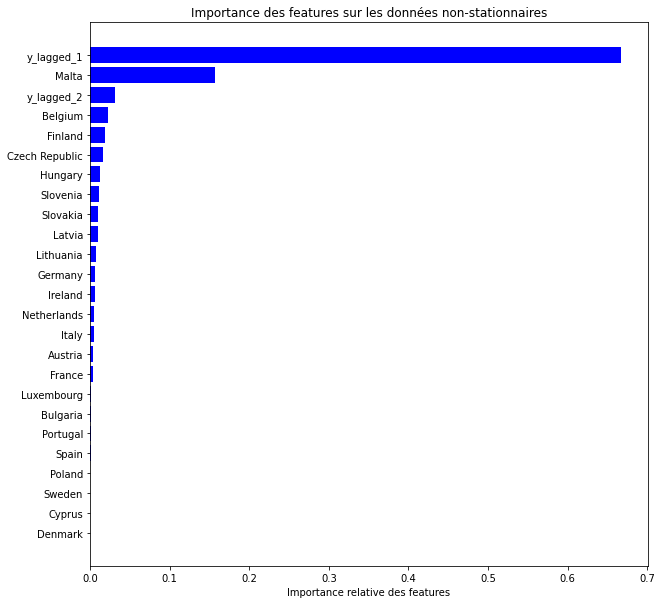

In [69]:
indices = np.argsort(rf_best_raw.feature_importances_)

plt.figure(figsize=(10,10))
plt.title('Importance des features sur les données non-stationnaires')
plt.barh(range(len(indices)), rf_best_raw.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_rf_train_diff.columns[i] for i in indices])
plt.xlabel('Importance relative des features')
plt.show()

On observe que sur les données stationnaires ou non, les taux laggués font parties des variables apportant le plus d'information a notre modèle et que l'apport des différentes features diminue significativement en dehors du premier lag. Dans ce contexte il aurait pu etre interessant de réduire la dimension de notre jeu de données notamment afin d'améliorer les performances de notre modèle et d'en réduire la compléxité. Toutefois, la dimensionnalité de notre jeu de donnée étant peu conséquante l'apport du retrait des variables est marginale. De plus, les scores affichés par notre prédicteur écarte le risque d'overfitting. Pour terminer, dans le livre de Kuhn & Johnson Effect of Irrelevant Features, les auteurs démontrent que l'algorithme du Random Forest reste robuste dans la limite de 200 variables "superflues".

In [70]:
y_train.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01'],
              dtype='datetime64[ns]', length=168, freq=None)

In [71]:
y_test.shift(1)

2017-01-01     NaN
2017-02-01    1.85
2017-03-01    1.85
2017-04-01    1.87
2017-05-01    1.87
              ... 
2022-08-01    2.26
2022-09-01    2.45
2022-10-01    2.67
2022-11-01    2.89
2022-12-01    2.94
Name: rates, Length: 72, dtype: float64

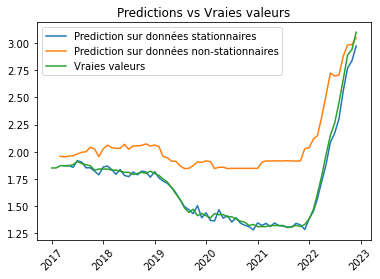

In [72]:
plt.plot(y_test.index[3:], y_test.loc[y_test.index[2:-1]] + predictions_diff_rf_test)
plt.plot(y_test.index[2:], predictions_raw_rf_test)
plt.plot(y_test)
plt.legend(['Prediction sur données stationnaires','Prediction sur données non-stationnaires','Vraies valeurs']);
plt.xticks(rotation = 45);
plt.title("Predictions vs Vraies valeurs");

# Lasso
Dans la mesure ou nous avons vu précedemment qu'un certain nombre de variables n'ont qu'un apport marginal dans la qualité de notre prédiction nous avons alors décidé d'adopter une approche de régularisation pour notre modèle, en utilisant la méthode LASSO. Le LASSO nous permet de pénaliser certains coefficients de manière à réduire leur impact sur la prédiction, voire à les annuler complètement. Cela nous permet de sélectionner uniquement les variables les plus importantes pour notre modèle. Pour déterminer la meilleure valeur de notre paramètre de régularisation, nous utilisons la technique de validation croisée, qui consiste à diviser nos données en plusieurs sous-ensembles et à évaluer les performances du modèle sur différentes combinaisons de ces sous-ensembles. En ajustant le paramètre de régularisation à l'aide de cette approche, nous pouvons choisir la valeur optimale qui minimise l'erreur de prédiction et évite l'overfitting du modèle. En combinant la régularisation LASSO avec la validation croisée, nous pouvons obtenir un modèle plus robuste et généralisable, en ne conservant que les variables pertinentes tout en évitant les problèmes d'overfitting.

In [73]:
X_lasso_train_diff = X_train.copy().diff()
y_lasso_train_diff = y_train.copy().diff()

In [74]:
X_lasso_train_diff['y_lagged_1'] = y_lasso_train_diff.shift(1)
X_lasso_train_diff['y_lagged_2'] = y_lasso_train_diff.shift(2)
X_lasso_train_diff = X_lasso_train_diff.dropna()
y_lasso_train_diff = y_lasso_train_diff.iloc[3:]
X_lasso_train_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-04-01     0.13     0.14     -0.14   -0.03            0.17     0.15   
2003-05-01    -0.31    -0.34     -0.01   -0.17           -0.19    -0.33   
2003-06-01    -0.09    -0.21      0.00    0.00           -0.24    -0.20   
2003-07-01     0.30     0.32     -0.83   -0.04            0.57     0.35   
2003-08-01     0.16     0.16     -0.04    0.00            0.17     0.16   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2003-04-01     0.15   0.15     0.14    0.12  ...    0.00  -0.15         0.22   
2003-05-01    -0.32  -0.31    -0.32   -0.33  ...   -0.04  -0.11        -0.32   
2003-06-01    -0.24  -0.19    -0.21   -0.20  ...   -0.06  -0.03        -0.19   
2003-07-01     0.32   0.34     0.31    0.32  ...   -0.11  -0.16         0.32   
2003-08-01     0.18   0.16     0.17    0.15  ...    0.02  -0.17         0.14   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2003-04-01   -0.11      0.10    0.15       0.0     -0.11       -0.07   
2003-05-01   -0.29     -0.27   -0.35       0.0     -0.18       -0.08   
2003-06-01   -0.09     -0.14   -0.17       0.0     -0.02       -0.15   
2003-07-01    0.34      0.33    0.31       0.0      0.10       -0.14   
2003-08-01    0.24      0.16    0.19       0.0      0.12        0.01   

            y_lagged_2  
2003-04-01       -0.13  
2003-05-01       -0.07  
2003-06-01       -0.08  
2003-07-01       -0.15  
2003-08-01       -0.14  

[5 rows x 25 columns]

In [75]:
X_lasso_test_diff = X_test.copy().diff() # without stationarity
y_lasso_test_diff = y_test.copy().diff()
X_lasso_test_diff['y_lagged_1'] = y_lasso_test_diff.shift(1)
X_lasso_test_diff['y_lagged_2'] = y_lasso_test_diff.shift(2)
X_lasso_test_diff = X_lasso_test_diff.dropna()
y_lasso_test_diff = y_lasso_test_diff.iloc[3:]
X_lasso_test_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2017-04-01    -0.10    -0.09      0.05   -0.11            0.09    -0.13   
2017-05-01     0.16    -0.01     -0.04   -0.20           -0.22     0.12   
2017-06-01    -0.10    -0.15     -0.04   -0.19            0.03    -0.09   
2017-07-01     0.18     0.21     -0.05   -0.27            0.13     0.21   
2017-08-01    -0.12    -0.10      0.05   -0.08           -0.07    -0.11   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2017-04-01     0.36  -0.11    -0.13   -0.14  ...   -0.02  -0.12         0.02   
2017-05-01     0.09  -0.04     0.11   -0.07  ...   -0.04  -0.06         0.09   
2017-06-01    -0.11  -0.12     0.07   -0.15  ...   -0.03  -0.12        -0.09   
2017-07-01     0.14   0.15     0.20    0.18  ...    0.13   0.11         0.19   
2017-08-01    -0.12  -0.12    -0.11   -0.13  ...   -0.13  -0.13        -0.15   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2017-04-01   -0.24     -0.22   -0.12      0.01     -0.03        0.02   
2017-05-01   -0.07     -0.48   -0.01     -0.02     -0.03        0.00   
2017-06-01   -0.16     -0.32   -0.10     -0.12     -0.17        0.00   
2017-07-01    0.11      0.05    0.20      0.29      0.07        0.01   
2017-08-01    0.03     -0.19   -0.03     -0.06     -0.10        0.03   

            y_lagged_2  
2017-04-01        0.00  
2017-05-01        0.02  
2017-06-01        0.00  
2017-07-01        0.00  
2017-08-01        0.01  

[5 rows x 25 columns]

In [76]:
reg = LassoCV(cv=5, random_state=42).fit(X_lasso_train_diff, y_lasso_train_diff)
pred_lasso_test = reg.predict(X_lasso_test_diff)
pred_lasso_train = reg.predict(X_lasso_train_diff)

In [77]:
y_lasso_test_diff

2017-04-01    0.00
2017-05-01    0.00
2017-06-01    0.01
2017-07-01    0.03
2017-08-01   -0.02
              ... 
2022-08-01    0.19
2022-09-01    0.22
2022-10-01    0.22
2022-11-01    0.05
2022-12-01    0.16
Name: rates, Length: 69, dtype: float64

In [78]:
print('The R2 of the model on train set is:',round(reg.score(X_lasso_train_diff, y_lasso_train_diff)*100,2))
print('The R2 of the model on test set is:',round(reg.score(X_lasso_test_diff, y_lasso_test_diff)*100,2))

The R2 of the model on train set is: 84.11
The R2 of the model on test set is: 74.37


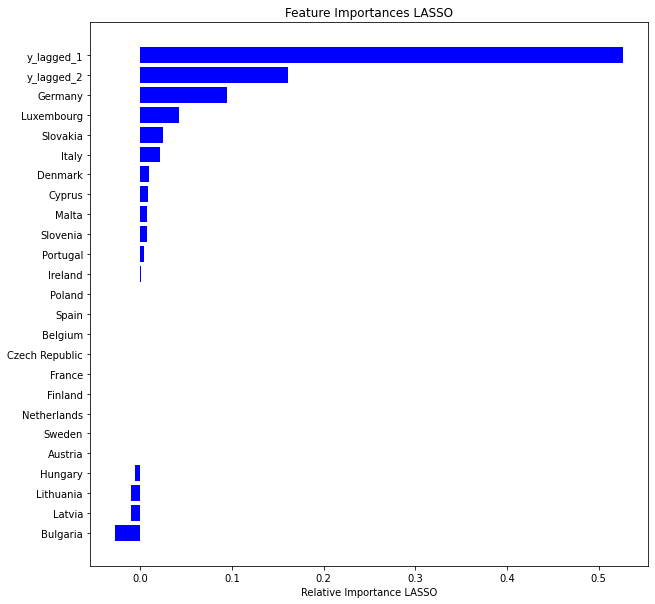

In [79]:
indices = np.argsort(reg.coef_)

plt.figure(figsize=(10,10))
plt.title('Feature Importances LASSO')
plt.barh(range(len(indices)), reg.coef_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_lasso_train_diff.columns[i] for i in indices])
plt.xlabel('Relative Importance LASSO')
plt.show()

Parmis les variables avec les coéficcients les plus hauts on retrouve de nouveau le décalage 1. On retrouve également L'Allamgne, les Pays-Bas, le Luxembourg et la Bulgarie.

In [80]:
print('Statistics Diff: Lasso')
print('MSE train set:')
print(round(mean_squared_error(y_train[3:], pred_lasso_train+ y_train[2:-1].values), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[3:], pred_lasso_test+ y_test[2:-1].values), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[3:], pred_lasso_train+ y_train[2:-1].values, squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[3:], pred_lasso_test+ y_test[2:-1].values, squared=False), 6))

Statistics Diff: Lasso
MSE train set:
0.000826
MSE test set:
0.001166
RMSE train set:
0.028738
RMSE test set:
0.034149


On observe pas d'overfitting: les erreurs du train sont equivalente à celle du test. 

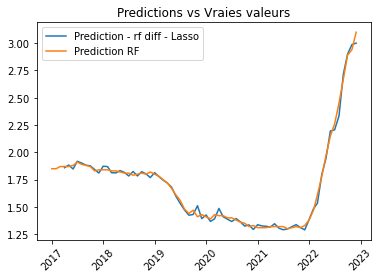

In [81]:
plt.plot(y_test.index[3:], y_test.loc[y_test.index[2:-1]] + pred_lasso_test)
plt.plot(y_test)
plt.legend(['Prediction - rf diff - Lasso','Prediction RF','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs Vraies valeurs");

## Gradient boosting

La méthode d'arret prématuré dans les méthodes d'ensemble permettent de trouver le nombre optimal d'arbre. Notre implémentation permet d'optimiser le nombre d'arbre avant de chercher les autres meilleur hyperparamètre du modèle.

In [82]:
X_gb_train_diff = X_train.copy().diff()
y_gb_train_diff = y_train.copy().diff()

X_gb_train_diff['y_lagged_1'] = y_gb_train_diff.shift(1)
X_gb_train_diff['y_lagged_2'] = y_gb_train_diff.shift(2)
X_gb_train_diff = X_gb_train_diff.dropna()
y_gb_train_diff = y_gb_train_diff.iloc[3:]
X_gb_train_diff.head()

X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(X_gb_train_diff, y_gb_train_diff, random_state=49)

In [83]:
X_gb_test_diff = X_test.copy().diff() # without stationarity
y_gb_test_diff = y_test.copy().diff()
X_gb_test_diff['y_lagged_1'] = y_gb_test_diff.shift(1)
X_gb_test_diff['y_lagged_2'] = y_gb_test_diff.shift(2)
X_gb_test_diff = X_gb_test_diff.dropna()
y_gb_test_diff = y_gb_test_diff.iloc[3:]
X_gb_test_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2017-04-01    -0.10    -0.09      0.05   -0.11            0.09    -0.13   
2017-05-01     0.16    -0.01     -0.04   -0.20           -0.22     0.12   
2017-06-01    -0.10    -0.15     -0.04   -0.19            0.03    -0.09   
2017-07-01     0.18     0.21     -0.05   -0.27            0.13     0.21   
2017-08-01    -0.12    -0.10      0.05   -0.08           -0.07    -0.11   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2017-04-01     0.36  -0.11    -0.13   -0.14  ...   -0.02  -0.12         0.02   
2017-05-01     0.09  -0.04     0.11   -0.07  ...   -0.04  -0.06         0.09   
2017-06-01    -0.11  -0.12     0.07   -0.15  ...   -0.03  -0.12        -0.09   
2017-07-01     0.14   0.15     0.20    0.18  ...    0.13   0.11         0.19   
2017-08-01    -0.12  -0.12    -0.11   -0.13  ...   -0.13  -0.13        -0.15   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2017-04-01   -0.24     -0.22   -0.12      0.01     -0.03        0.02   
2017-05-01   -0.07     -0.48   -0.01     -0.02     -0.03        0.00   
2017-06-01   -0.16     -0.32   -0.10     -0.12     -0.17        0.00   
2017-07-01    0.11      0.05    0.20      0.29      0.07        0.01   
2017-08-01    0.03     -0.19   -0.03     -0.06     -0.10        0.03   

            y_lagged_2  
2017-04-01        0.00  
2017-05-01        0.02  
2017-06-01        0.00  
2017-07-01        0.00  
2017-08-01        0.01  

[5 rows x 25 columns]

Ici, nous faisons un gradient boosting et un grid search afin d'optimiser les hypermarametres. 

In [84]:
# define the parameters on which ti apply the gird search

gbm = GradientBoostingRegressor(max_depth=2, n_estimators=150, learning_rate=0.1, random_state=42)

gbm.fit(X_gb_train_diff, y_gb_train_diff)

errors = [mean_squared_error(y_val_gb, y_pred)
          for y_pred in gbm.staged_predict(X_val_gb)]

In [85]:
print(round(np.min(errors), 5), 'is the smallest errors')
bst_n_estimators = np.argmin(errors) + 1
print(bst_n_estimators, 'is the optimal trees for the model and the input hyperparameters')

0.00015 is the smallest errors
150 is the optimal trees for the model and the input hyperparameters


In [86]:
# define the parameters on which ti apply the gird search
params = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'n_estimators' : [bst_n_estimators]
}


gbm = GradientBoostingRegressor(random_state=42)


grid_search = GridSearchCV(gbm, param_grid=params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_gb_train_diff, y_gb_train_diff)

# Get the best hyperparameters from the GridSearchCV object
best_params = grid_search.best_params_

# Instantiate the Gradient Boosting Regressor with the best hyperparameters
gbm = GradientBoostingRegressor(**best_params, random_state=42)

# Fit the model to the training data
gbm.fit(X_gb_train_diff, y_gb_train_diff)
print('The R2 of the model on train set is:',round(gbm.score(X_gb_train_diff, y_gb_train_diff)*100,2))
print('The R2 of the model on test set is:',round(gbm.score(X_gb_test_diff.dropna(), y_gb_test_diff)*100,2))

The R2 of the model on train set is: 97.62
The R2 of the model on test set is: 55.21


In [87]:
# Predict the target variable on the test set
y_pred_gbm = gbm.predict(X_gb_test_diff.dropna())
y_pred_train_gb = gbm.predict(X_gb_train_diff.dropna())

print('Statistics Diff: GB')
print('MSE train set:')
print(round(mean_squared_error(y_train[3:], y_pred_train_gb+ y_train[2:-1].values), 6))

print('MSE test set:')
print(round(mean_squared_error(y_test[3:], y_pred_gbm+ y_test[2:-1].values), 6))

print('RMSE train set:')
print(round(mean_squared_error(y_train[3:], y_pred_train_gb+ y_train[2:-1].values, squared =False), 6))

print('RMSE test set:')
print(round(mean_squared_error(y_test[3:], y_pred_gbm+ y_test[2:-1].values, squared=False), 6))



Statistics Diff: GB
MSE train set:
0.000124
MSE test set:
0.002038
RMSE train set:
0.011123
RMSE test set:
0.045145


On observe de l'overfitting: les erreurs sur le train set sont plus faible que sur le test set. 

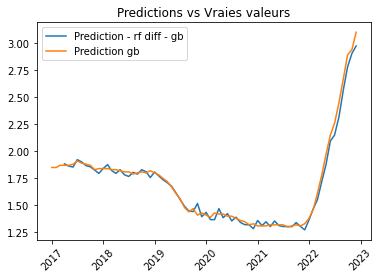

In [88]:
plt.plot(y_test.index[3:], y_test.loc[y_test.index[2:-1]] + y_pred_gbm)
plt.plot(y_test)
plt.legend(['Prediction - rf diff - gb','Prediction gb','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs Vraies valeurs");

On observe que finalement le Forest et le Gradient boosting ont les résultats les plus faible.

## KMeans et PCA

Enfin, nous avons exploré l'idée de partitionner notre jeu de données en sous-ensembles distincts à l'aide de la méthode KMeans. L'objectif principal était d'évaluer la pertinence de trouver des modèles adaptés à chaque sous-ensemble de données parmi les différentes approches que nous avons utilisées précédemment. En regroupant les données en clusters, nous avons cherché à identifier des structures sous-jacentes et à déterminer si des modèles spécifiques peuvent mieux s'adapter à chaque groupe. Cette approche nous permet d'explorer davantage les nuances des données et de rechercher des relations plus spécifiques entre les variables, ce qui peut potentiellement améliorer la précision de nos prédictions pour chaque sous-ensemble de données.

In [89]:
X_kmeans_train_diff = X_train.copy().diff()
y_kmeans_train_diff = y_train.copy().diff()

X_kmeans_train_diff['y_lagged_1'] = y_kmeans_train_diff.shift(1)
X_kmeans_train_diff['y_lagged_2'] = y_kmeans_train_diff.shift(2)
X_kmeans_train_diff = X_kmeans_train_diff.dropna()
y_kmeans_train_diff = y_kmeans_train_diff.iloc[3:]
X_kmeans_train_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-04-01     0.13     0.14     -0.14   -0.03            0.17     0.15   
2003-05-01    -0.31    -0.34     -0.01   -0.17           -0.19    -0.33   
2003-06-01    -0.09    -0.21      0.00    0.00           -0.24    -0.20   
2003-07-01     0.30     0.32     -0.83   -0.04            0.57     0.35   
2003-08-01     0.16     0.16     -0.04    0.00            0.17     0.16   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2003-04-01     0.15   0.15     0.14    0.12  ...    0.00  -0.15         0.22   
2003-05-01    -0.32  -0.31    -0.32   -0.33  ...   -0.04  -0.11        -0.32   
2003-06-01    -0.24  -0.19    -0.21   -0.20  ...   -0.06  -0.03        -0.19   
2003-07-01     0.32   0.34     0.31    0.32  ...   -0.11  -0.16         0.32   
2003-08-01     0.18   0.16     0.17    0.15  ...    0.02  -0.17         0.14   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2003-04-01   -0.11      0.10    0.15       0.0     -0.11       -0.07   
2003-05-01   -0.29     -0.27   -0.35       0.0     -0.18       -0.08   
2003-06-01   -0.09     -0.14   -0.17       0.0     -0.02       -0.15   
2003-07-01    0.34      0.33    0.31       0.0      0.10       -0.14   
2003-08-01    0.24      0.16    0.19       0.0      0.12        0.01   

            y_lagged_2  
2003-04-01       -0.13  
2003-05-01       -0.07  
2003-06-01       -0.08  
2003-07-01       -0.15  
2003-08-01       -0.14  

[5 rows x 25 columns]

In [90]:
X_kmeans_test_diff = X_test.copy().diff() # without stationarity
y_kemans_test_diff = y_test.copy().diff()
X_kmeans_test_diff['y_lagged_1'] = y_kemans_test_diff.shift(1)
X_kmeans_test_diff['y_lagged_2'] = y_kemans_test_diff.shift(2)
X_kmeans_test_diff = X_kmeans_test_diff.dropna()
y_kemans_test_diff = y_kemans_test_diff.iloc[3:]
X_kmeans_test_diff.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2017-04-01    -0.10    -0.09      0.05   -0.11            0.09    -0.13   
2017-05-01     0.16    -0.01     -0.04   -0.20           -0.22     0.12   
2017-06-01    -0.10    -0.15     -0.04   -0.19            0.03    -0.09   
2017-07-01     0.18     0.21     -0.05   -0.27            0.13     0.21   
2017-08-01    -0.12    -0.10      0.05   -0.08           -0.07    -0.11   

            Denmark  Spain  Finland  France  ...  Latvia  Malta  Netherlands  \
2017-04-01     0.36  -0.11    -0.13   -0.14  ...   -0.02  -0.12         0.02   
2017-05-01     0.09  -0.04     0.11   -0.07  ...   -0.04  -0.06         0.09   
2017-06-01    -0.11  -0.12     0.07   -0.15  ...   -0.03  -0.12        -0.09   
2017-07-01     0.14   0.15     0.20    0.18  ...    0.13   0.11         0.19   
2017-08-01    -0.12  -0.12    -0.11   -0.13  ...   -0.13  -0.13        -0.15   

            Poland  Portugal  Sweden  Slovenia  Slovakia  y_lagged_1  \
2017-04-01   -0.24     -0.22   -0.12      0.01     -0.03        0.02   
2017-05-01   -0.07     -0.48   -0.01     -0.02     -0.03        0.00   
2017-06-01   -0.16     -0.32   -0.10     -0.12     -0.17        0.00   
2017-07-01    0.11      0.05    0.20      0.29      0.07        0.01   
2017-08-01    0.03     -0.19   -0.03     -0.06     -0.10        0.03   

            y_lagged_2  
2017-04-01        0.00  
2017-05-01        0.02  
2017-06-01        0.00  
2017-07-01        0.00  
2017-08-01        0.01  

[5 rows x 25 columns]

In [91]:
range_n_clusters = [*range(2, 11)]
best_n_clusters = 1
best_score=-1
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_kmeans_train_diff, y_kmeans_train_diff)

    silhouette_avg = silhouette_score(X_kmeans_train_diff, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    if (best_n_clusters ==1) | (silhouette_avg > best_score):
        best_score = silhouette_avg
        best_n_clusters = n_clusters

For n_clusters = 2 The average silhouette_score is : 0.2252681216258104
For n_clusters = 3 The average silhouette_score is : 0.21875412420371856
For n_clusters = 4 The average silhouette_score is : 0.2201464449612701
For n_clusters = 5 The average silhouette_score is : 0.12250016143754935
For n_clusters = 6 The average silhouette_score is : 0.17063509920535644
For n_clusters = 7 The average silhouette_score is : 0.17427744511729543
For n_clusters = 8 The average silhouette_score is : 0.15890568509920555
For n_clusters = 9 The average silhouette_score is : 0.11703963327146669
For n_clusters = 10 The average silhouette_score is : 0.11621583108590706


In [92]:
pipelineKMeans = Pipeline([
 ('scaler', StandardScaler()),
('kmeans', KMeans(n_clusters=best_n_clusters, random_state=42))
])

# Fit the pipeline on the training data
pipelineKMeans.fit(X_kmeans_train_diff, y_kmeans_train_diff)
# Predict on the test data
X_kmeans_train_diff['y_pred'] = pipelineKMeans.predict(X_kmeans_train_diff)

In [93]:
pipelineKMeans.named_steps['kmeans'].inertia_

2955.7159556193824

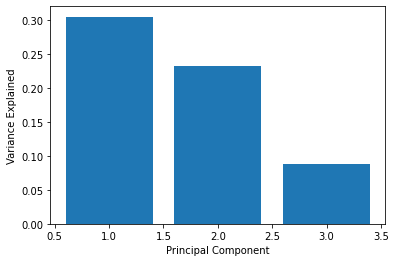

In [94]:
pca = PCA(n_components=3)
pca_result = pd.DataFrame(pca.fit_transform(X_kmeans_train_diff.iloc[:, :-1]), columns=['PCA_1', 'PCA_2', 'PCA_3'])
pca_result['y_pred'] = X_kmeans_train_diff['y_pred'].values
plt.bar(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [95]:
clusters = []
for label in set(X_kmeans_train_diff['y_pred'].values):
    cluster_data = pca_result[pca_result['y_pred'] == label]
    cluster = go.Scatter3d(
        x=cluster_data['PCA_1'],
        y=cluster_data['PCA_2'],
        z=cluster_data['PCA_3'],
        mode='markers',
        name=f'Cluster {label}',
        marker=dict(
            size=5,
            color=['red', 'blue', 'green', 'grey'][label],
            opacity=0.8
        )
    )
    clusters.append(cluster)

layout = go.Layout(
    title='KMeans Clustering in 3D',
    scene=dict(
        xaxis=dict(title='PCA_1'),
        yaxis=dict(title='PCA_2'),
        zaxis=dict(title='PCA_3')
    )
)

fig = go.Figure(data=clusters, layout=layout)
fig.show()

Selection de modèle pour chaque classe

In [96]:
# Define the models to be tested
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [5, 50, 100, 200],
            'model__max_depth': [2, 5, 10],
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [5, 50, 100, 200],
            'model__max_depth': [2, 5, 10],
        }
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10, 100]
        }
    }
]

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', None)
])


In [97]:
# Perform the grid search for each model
for label in set(X_kmeans_train_diff['y_pred'].values):
    globals()['best_score'+str(label)] = -1
    print('Cluster'+str(label))
    cluster_data = X_kmeans_train_diff[X_kmeans_train_diff['y_pred'] == label]
    idx = cluster_data.index
    for model in models:
        print(f'Testing {model["name"]}...')
        pipe.set_params(model=model['model'])
        globals()['grid' + str(label)] = GridSearchCV(pipe, param_grid=model['params'], cv=5)
        globals()['grid' + str(label)].fit(cluster_data.iloc[:, :-1], y_kmeans_train_diff.loc[idx])
        best_score = globals()["grid" + str(label)].best_score_
        best_params= globals()["grid" + str(label)].best_params_
        if (globals()['best_score'+str(label)]==-1) | (best_score > globals()['best_score'+str(label)]):
            print({k.split('__')[1]: v for k, v in best_params.items()})
            globals()['model'+str(label)] = eval(str(model['model'])[:-2])(**{k.split('__')[1]: v for k, v in best_params.items()})
            globals()['best_score'+str(label)] = best_score
            globals()['best_params'+str(label)] = best_params              
        

Cluster0
Testing RandomForestRegressor...
{'max_depth': 5, 'n_estimators': 50}
Testing GradientBoostingRegressor...
Testing Lasso...
Cluster1
Testing RandomForestRegressor...
{'max_depth': 10, 'n_estimators': 50}
Testing GradientBoostingRegressor...
{'max_depth': 2, 'n_estimators': 50}
Testing Lasso...
{'alpha': 0.01}


In [98]:
for i in range(best_n_clusters):
    print('best model label :'+str(i))
    print(globals()['model'+str(i)])
    print('---------------------------------------------------------------')

best model label :0
RandomForestRegressor(max_depth=5, n_estimators=50)
---------------------------------------------------------------
best model label :1
Lasso(alpha=0.01)
---------------------------------------------------------------


In [99]:
pipelines = []

for i in range(best_n_clusters):
    pipelines.append(Pipeline([
        ('scaler', StandardScaler()),
        ('model', globals()['model'+str(i)])
    ]))
pipelines

[Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', RandomForestRegressor(max_depth=5, n_estimators=50))]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', Lasso(alpha=0.01))])]

In [100]:
for i, pipeline in enumerate(pipelines):
        cluster_data = X_kmeans_train_diff[X_kmeans_train_diff['y_pred'] == i]
        idx = cluster_data.index
        print(f"Training pipeline {i}...")
        pipelines[i].fit(cluster_data.iloc[:, :-1], y_kmeans_train_diff.loc[cluster_data.iloc[:, :-1].index])

Training pipeline 0...
Training pipeline 1...


In [101]:
y_pred = pd.DataFrame()
X_kmeans_test_diff['y_pred_clustering'] = pipelineKMeans.predict(X_kmeans_test_diff)
for i, pipeline in enumerate(pipelines):
    cluster_data = X_kmeans_test_diff[X_kmeans_test_diff['y_pred_clustering'] == i]
    idx = cluster_data.index
    print('Predict '+str(i))
    y_pred = pd.concat([y_pred, pd.DataFrame(pipelines[i].predict(cluster_data.iloc[:, :-1]), index=idx)])

y_pred.sort_index(inplace=True)
y_pred['y_true'] = y_test   
y_pred.columns = ['y_pred', 'y_test']

Predict 0
Predict 1


In [102]:
mse=round(np.mean((y_pred['y_pred'] - y_pred['y_test'])**2), 3)
print('MSE of the model: ' +str(mse))

MSE of the model: 3.003


In [103]:
round(np.mean((y_pred['y_pred'] - y_pred['y_test'])**2), 3)

3.003

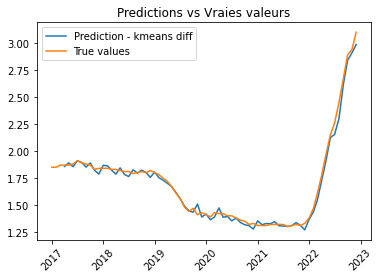

In [104]:
plt.plot(y_test.index[3:], y_test.loc[y_test.index[2:-1]] + y_pred['y_pred'].values)
plt.plot(y_test)
plt.legend(['Prediction - kmeans diff','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs Vraies valeurs");